# Определение возраста покупателей

## Исследовательский анализ данных

In [80]:
#подключаем библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

In [81]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [82]:
labels.head(5)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [83]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [90]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

In [84]:
#создаем загрузчик данных
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [85]:
#посмотрим на размер выборки
features, target = next(train_gen_flow)
print(features.shape)

(32, 224, 224, 3)


In [86]:
#размер одного изображение, соответственно
print(features[0].shape)

(224, 224, 3)


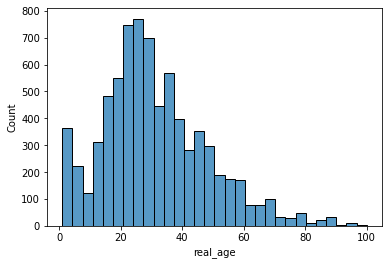

In [87]:
#построим график распределения возраста в выборке 
sns.histplot(labels['real_age'], bins=30);

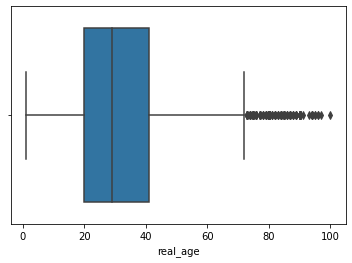

In [88]:
sns.boxplot(labels['real_age']);

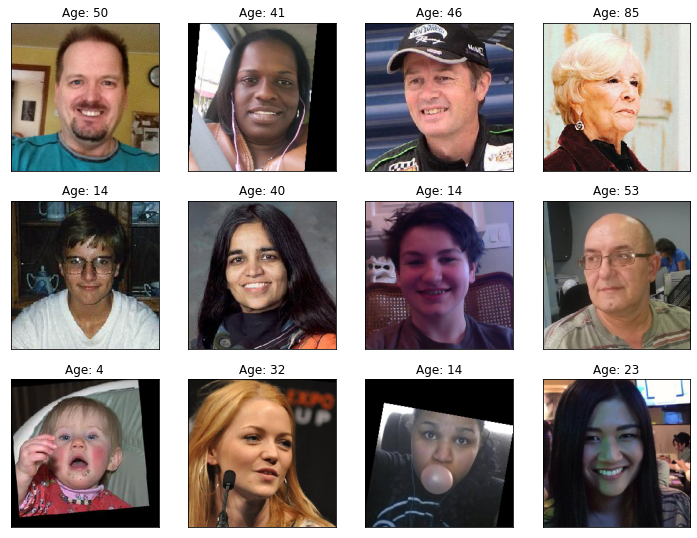

In [89]:
#выведем 12 фотографий из первого батча
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4,4,i+1)
    plt.title('Age: ' + str(target[i]))
    plt.imshow(features[i])
    
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Вывод: видно, что некоторые фотографии перевернуты, некоторые могут быть немного смещены от центра. Следует принять во внимание возможность аугметации выборки, возможно добавить горизонтальный флип.

## Обучение модели


Код запускался в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications.resnet import ResNet50, ResNet101
from tensorflow.keras.optimizers import Adam
import pandas as pd

def load_train(path):
    
    labels = pd.read_csv(path + 'labels.csv')
    train_data = ImageDataGenerator(rescale=1./255, 
                                    horizontal_flip=True,
                                    width_shift_range=0.1,
                                    rotation_range = 10,
                                    validation_split=0.25)
    train_data = train_data.flow_from_dataframe(dataframe=labels,
                                                directory=path + 'final_files/',
                                                x_col='file_name',
                                                y_col='real_age',
                                                target_size=(224,224),
                                                batch_size=32,
                                                class_mode='raw',
                                                subset='training',
                                                seed=12345)
    
    return train_data

def load_test(path):
    
    labels = pd.read_csv(path + 'labels.csv')
    test_data = ImageDataGenerator(rescale=1./255,    
                                      validation_split=0.25)
    test_data = test_data.flow_from_dataframe(dataframe=labels,
                                              directory=path + 'final_files/',
                                              x_col='file_name',
                                              y_col='real_age',
                                              target_size=(224,224),
                                              batch_size=32,
                                              class_mode='raw',
                                              subset='validation',
                                              seed=12345)
    
    return test_data

def create_model(input_shape):
    
    backbone = ResNet101(input_shape=input_shape,
                         weights='imagenet',
                         include_top=False)
    
    backbone.trainable = True
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model

def train_model(model, train_data, test_data, batch_size = None, epochs=20, steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
      
    model.fit(train_data,
              validation_data= test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              shuffle=True,
              verbose=2)
    
    return model

```

```

Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 178 steps, validate for 60 steps
Epoch 1/20
178/178 - 201s - loss: 208.7560 - mae: 10.4067 - val_loss: 616.1073 - val_mae: 19.8149
Epoch 2/20
178/178 - 89s - loss: 81.1607 - mae: 6.8204 - val_loss: 603.6823 - val_mae: 19.4182
Epoch 3/20
178/178 - 89s - loss: 60.0147 - mae: 5.8975 - val_loss: 216.5445 - val_mae: 11.0462
Epoch 4/20
178/178 - 89s - loss: 47.0171 - mae: 5.2475 - val_loss: 156.8334 - val_mae: 9.5135
Epoch 5/20
178/178 - 89s - loss: 35.8282 - mae: 4.6026 - val_loss: 87.5546 - val_mae: 7.0123
Epoch 6/20
178/178 - 89s - loss: 31.2746 - mae: 4.3200 - val_loss: 71.7155 - val_mae: 6.3072
Epoch 7/20
178/178 - 89s - loss: 25.2313 - mae: 3.8728 - val_loss: 79.5480 - val_mae: 6.7189
Epoch 8/20
178/178 - 89s - loss: 22.9503 - mae: 3.6803 - val_loss: 72.2542 - val_mae: 6.5385
Epoch 9/20
178/178 - 88s - loss: 20.2405 - mae: 3.4531 - val_loss: 77.8039 - val_mae: 6.4736
Epoch 10/20
178/178 - 89s - loss: 17.7227 - mae: 3.2605 - val_loss: 64.9075 - val_mae: 5.9872
Epoch 11/20
178/178 - 89s - loss: 16.6780 - mae: 3.1437 - val_loss: 65.5980 - val_mae: 6.0835
Epoch 12/20
178/178 - 89s - loss: 14.1673 - mae: 2.8647 - val_loss: 72.9580 - val_mae: 6.4417
Epoch 13/20
178/178 - 88s - loss: 14.1540 - mae: 2.8759 - val_loss: 63.8690 - val_mae: 5.9663
Epoch 14/20
178/178 - 89s - loss: 12.3527 - mae: 2.6678 - val_loss: 64.5595 - val_mae: 5.9759
Epoch 15/20
178/178 - 88s - loss: 10.4606 - mae: 2.4806 - val_loss: 62.5838 - val_mae: 5.8360
Epoch 16/20
178/178 - 88s - loss: 10.0278 - mae: 2.4209 - val_loss: 67.6685 - val_mae: 6.0617
Epoch 17/20
178/178 - 89s - loss: 10.6313 - mae: 2.4578 - val_loss: 69.7831 - val_mae: 6.3927
Epoch 18/20
178/178 - 89s - loss: 8.7442 - mae: 2.2481 - val_loss: 56.9885 - val_mae: 5.7051
Epoch 19/20
178/178 - 89s - loss: 9.2764 - mae: 2.2952 - val_loss: 68.8120 - val_mae: 6.0708
Epoch 20/20
178/178 - 89s - loss: 9.2810 - mae: 2.3391 - val_loss: 68.6071 - val_mae: 6.0588

60/60 - 9s - loss: 68.6071 - mae: 6.0588
Test MAE: 6.0588

```

## Анализ обученной модели

- Для обучения была выбрана модель на основе ResNet101 с предобученными весами на датасете imagenet. Данные разбиты на обучающую и валидационную выборку в отношении 3:1. Оптимизатор модели Adam со скоростью обучения learning_rate=0.0001. Функция потерь - mse, метрика качества модели - mae.
- Модель показала хорошие результаты на валидационной выборке уже после 10-ой эпохи: train_mae=mae: 3.2605, val_mae: 5.9872. Далее видно улучшение по результату mae в тренировочной выборке, при этом на валидационной выборке точность почти не изменялась, результаты на валидационной выборке после 20-ой эпохи: train_mae=mae: 2.3391, val_mae: 6.0588.